Importing Libraries

In [73]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf


Loading Dataset

In [74]:
dataset = pd.read_csv(r"C:\Datasets\Time_Series\Electric_Production.csv")
dataset.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


Knowing the dataset

In [75]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        397 non-null    object 
 1   IPG2211A2N  397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


In [76]:
dataset.describe()

,IPG2211A2N
count,397.000000
mean,88.847218
std,15.387834
min,55.315100
25%,77.105200
50%,89.779500
75%,100.524400
max,129.404800


Data Visualization

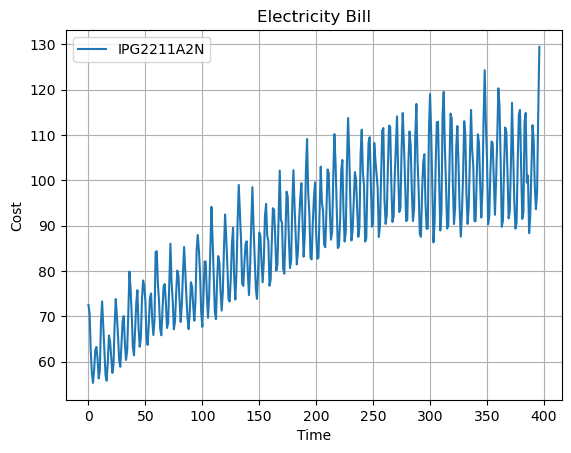

In [77]:
dataset.plot()

plt.xlabel('Time')
plt.ylabel('Cost')
plt.title('Electricity Bill')
plt.grid(True)

In [78]:
#dataset= tunnel.copy()

dataset['Time'] = np.arange(len(dataset.index))

dataset.head()

,DATE,IPG2211A2N,Time
0,1/1/1985,72.5052,0
1,2/1/1985,70.6720,1
2,3/1/1985,62.4502,2
3,4/1/1985,57.4714,3
4,5/1/1985,55.3151,4


In [79]:
time = dataset.loc[:, ['Time']]  # features
cost = dataset.loc[:, 'IPG2211A2N']  

Spliting the Dataset

In [80]:
split_time = 320
time_train = time[:split_time]
cost_train = cost[:split_time]

time_valid = time[split_time:]
cost_valid = cost[split_time:]

Features and Labels

In [81]:
window_size = 25
batch_size = 10
shuffle_buffer_size = 500

def windowed_dataset(cost, window_size, batch_size, shuffle_buffer):
  
    # Generate a TF Dataset 
    dataset = tf.data.Dataset.from_tensor_slices(cost)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [82]:
dataset = windowed_dataset(cost, window_size, batch_size, shuffle_buffer_size)

Testing Model


In [83]:

model1 = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x:tf.expand_dims(x, axis = -1), input_shape= [window_size]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x:x*100)
]
)

In [84]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 25, 1)             0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 25, 64)            8704      
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
 lambda_3 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 33601 (131.25 KB)
Trainable params: 3360

Tuning the learning rate

In [85]:
lr_scheduling = tf.keras.callbacks.LearningRateScheduler(lambda epoch:1e-8* 10 **(epoch/20))

optimizer = tf.keras.optimizers.SGD(momentum=0.9)

model1.compile(loss= tf.keras.losses.Huber(), optimizer=optimizer)

history = model1.fit(dataset, epochs=100, callbacks=[lr_scheduling])


Epoch 1/100
38/38 [==============================] - 15s 22ms/step - loss: 63.1595 - lr: 1.0000e-08
Epoch 2/100
38/38 [==============================] - 1s 19ms/step - loss: 61.6848 - lr: 1.1220e-08
Epoch 3/100
38/38 [==============================] - 1s 18ms/step - loss: 59.8294 - lr: 1.2589e-08
Epoch 4/100
38/38 [==============================] - 1s 18ms/step - loss: 57.5649 - lr: 1.4125e-08
Epoch 5/100
38/38 [==============================] - 1s 19ms/step - loss: 54.7389 - lr: 1.5849e-08
Epoch 6/100
38/38 [==============================] - 1s 19ms/step - loss: 51.1394 - lr: 1.7783e-08
Epoch 7/100
38/38 [==============================] - 1s 18ms/step - loss: 46.6719 - lr: 1.9953e-08
Epoch 8/100
38/38 [==============================] - 1s 20ms/step - loss: 41.8363 - lr: 2.2387e-08
Epoch 9/100
38/38 [==============================] - 1s 21ms/step - loss: 37.6748 - lr: 2.5119e-08
Epoch 10/100
38/38 [==============================] - 1s 18ms/step - loss: 34.3055 - lr: 2.8184e-08
Epoch 11

Plotting Learning rate vs Loss

(1e-08, 0.001, 0.0, 30.0)

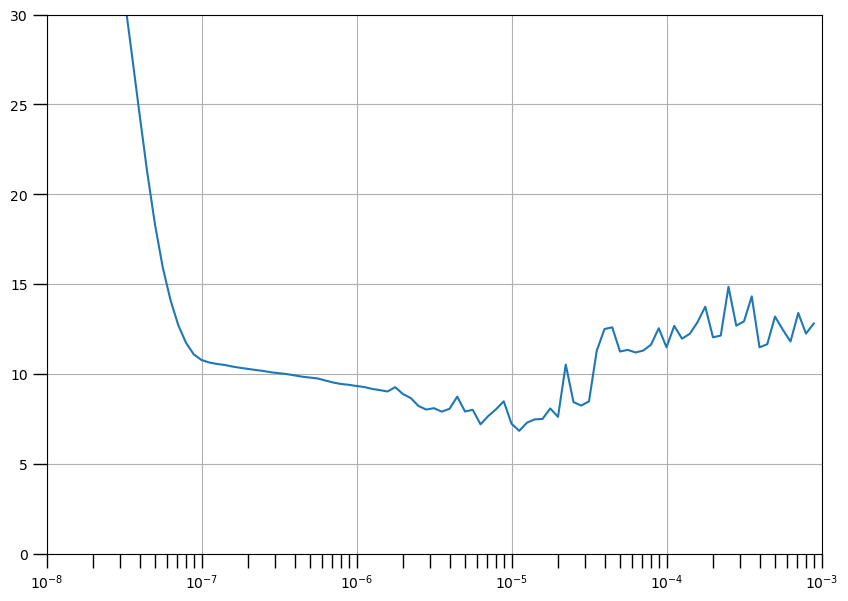

In [86]:
lrs = 1e-8 * (10** (np.arange(100)/ 20))

plt.figure(figsize=(10,7))
plt.grid()

plt.semilogx(lrs, history.history['loss'])
plt.tick_params('both', length=10, width=1, which='both')

plt.axis([1e-8, 1e-3, 0, 30])

Tuned Model 

In [87]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 2e-5

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)

Epoch 1/100
38/38 [==============================] - 18s 26ms/step - loss: 22.2859 - mae: 22.7824
Epoch 2/100
38/38 [==============================] - 1s 22ms/step - loss: 11.5940 - mae: 12.0798
Epoch 3/100
38/38 [==============================] - 1s 23ms/step - loss: 10.5297 - mae: 11.0213
Epoch 4/100
38/38 [==============================] - 1s 21ms/step - loss: 9.5961 - mae: 10.0812
Epoch 5/100
38/38 [==============================] - 1s 21ms/step - loss: 10.1822 - mae: 10.6778
Epoch 6/100
38/38 [==============================] - 1s 23ms/step - loss: 8.2521 - mae: 8.7440
Epoch 7/100
38/38 [==============================] - 1s 21ms/step - loss: 14.4402 - mae: 14.9382
Epoch 8/100
38/38 [==============================] - 1s 21ms/step - loss: 10.0006 - mae: 10.4949
Epoch 9/100
38/38 [==============================] - 1s 23ms/step - loss: 8.8684 - mae: 9.3632
Epoch 10/100
38/38 [==============================] - 1s 22ms/step - loss: 8.0245 - mae: 8.5145
Epoch 11/100
38/38 [===============

Prediction

38/38 [==============================] - 4s 11ms/step


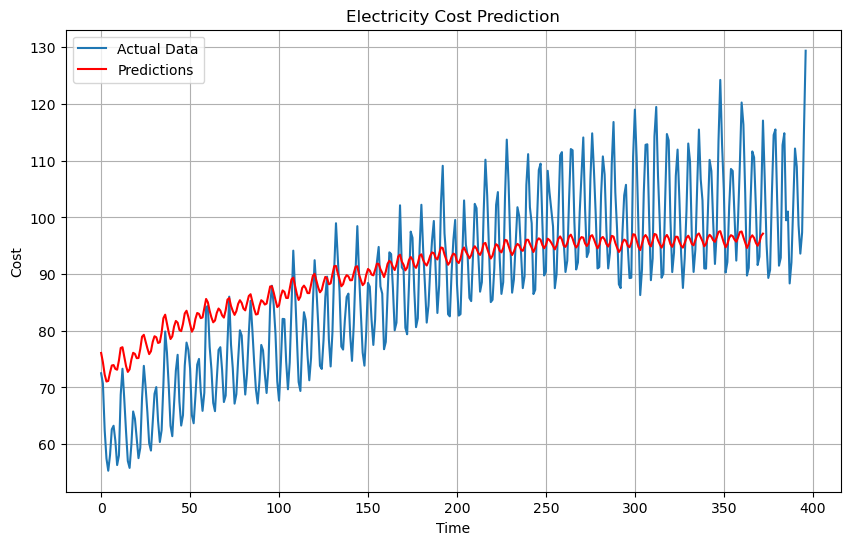

Mean Squared Error: 98.05413947848471
Mean Absolute Error: 8.39692917323381


In [88]:
# Use the entire cost series for forecasting
forecast_series = cost

# Define a function to generate predictions using the trained model
def model_forecast(model, series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset)
    return forecast

# Use the model_forecast function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(cost)), cost, label='Actual Data')

# Adjust the length of predictions to match the length of actual data
if len(cost) > len(results):
    pad_width = len(cost) - len(results)
    results_padded = np.pad(results, (0, pad_width), 'constant', constant_values=np.nan)
    plt.plot(np.arange(len(cost)), results_padded, label='Predictions', color='red')
else:
    plt.plot(np.arange(len(results)), results, label='Predictions', color='red')

plt.xlabel('Time')
plt.ylabel('Cost')
plt.title('Electricity Cost Prediction')
plt.legend()
plt.grid(True)
plt.show()


## Calculate MSE and MAE
mse = mean_squared_error(cost[:len(results)], results)
mae = mean_absolute_error(cost[:len(results)], results)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')


Arima Model

                               SARIMAX Results                                
Dep. Variable:             IPG2211A2N   No. Observations:                  397
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1100.930
Date:                Fri, 31 May 2024   AIC                           2213.861
Time:                        16:29:42   BIC                           2237.749
Sample:                             0   HQIC                          2223.325
                                - 397                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0650      0.044     -1.488      0.137      -0.151       0.021
ar.L2         -0.4828      0.049     -9.859      0.000      -0.579      -0.387
ar.L3         -0.5190      0.047    -11.102      0.0

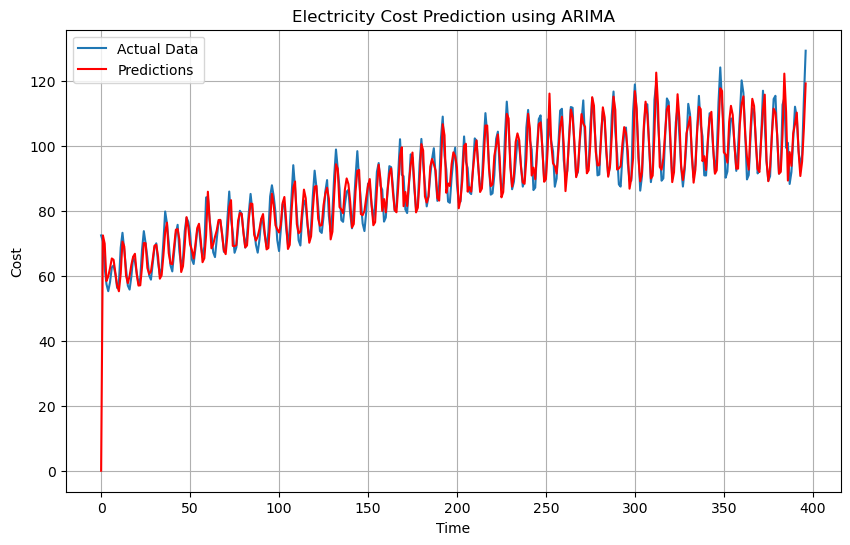

Mean Squared Error: 28.402992020310162
Mean Absolute Error: 3.185529144102051


In [89]:
model = ARIMA(cost, order=(5, 1, 0))  # (p, d, q) values need tuning
arima_result = model.fit()
print(arima_result.summary())

# Make predictions for the entire dataset
predictions = arima_result.predict(start=0, end=len(cost)-1, typ='levels')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(cost, label='Actual Data')
plt.plot(predictions, label='Predictions', color='red')
plt.xlabel('Time')
plt.ylabel('Cost')
plt.title('Electricity Cost Prediction using ARIMA')
plt.legend()
plt.grid(True)
plt.show()

# Calculate MSE and MAE
mse = mean_squared_error(cost, predictions)
mae = mean_absolute_error(cost, predictions)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
